In [64]:
# Activate environment:
#source /content/drive/MyDrive/fp-dataset-artifacts-main/project_env/bin/activate

"""
# First, remove the env folder

apt install python3.10-venv

python3 -m venv /content/project_env

source /content/project_env/bin/activate

pip install --upgrade pip

pip install -r /content/drive/MyDrive/fp-dataset-artifacts-main/requirements.txt

pip install scikit-learn captum nltk
"""

'\n# First, remove the env folder\n\napt install python3.10-venv\n\npython3 -m venv /content/project_env\n\nsource /content/project_env/bin/activate\n\npip install --upgrade pip\n\npip install -r /content/drive/MyDrive/fp-dataset-artifacts-main/requirements.txt\n\npip install scikit-learn captum nltk \n'

In [65]:
# Install captum for visualization
!pip install captum
!pip install datasets

In [88]:
import torch
import argparse
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

def forward_func(embeddings, attention_mask, model):
    """
    Custom forward function for Integrated Gradients.
    Accepts embeddings and attention mask, and returns logits from the model.
    """
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    logits = outputs.logits
    return logits

def get_token_attributions(model, tokenizer, premise, hypothesis, target_label=None):
    """
    Compute Integrated Gradients for a given premise/hypothesis pair.
    """
    # Tokenize input sentences
    inputs = tokenizer(premise, hypothesis, return_tensors='pt', truncation=True)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)

    # Extract embeddings from input IDs
    embeddings = model.get_input_embeddings()(input_ids)

    # Do forward pass to get preds
    with torch.no_grad():
        logits = forward_func(embeddings, attention_mask, model)
    preds = torch.softmax(logits, dim=-1)
    pred_label = torch.argmax(preds, dim=1).item()

    # No target label provided? Default to predicted label
    if target_label is None:
        target_label = pred_label

    # Init Integrated Gradients and define baseline
    ig = IntegratedGradients(lambda emb: forward_func(emb, attention_mask, model))
    baseline = torch.zeros_like(embeddings)

    # Compute attributions for target label
    attributions = ig.attribute(embeddings, baseline, target=target_label, n_steps=50)
    token_attributions = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()

    # Convert input IDs back to readable tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return tokens, token_attributions, pred_label


def main(args=None, **kwargs):
    """
    Main function to handle token attribution and visualization.
    Accepts either an argparse.Namespace object (args) or keyword arguments.
    """
    # If no args are passed, assume kwargs were used
    if args is None:
        class Args:
            pass
        args = Args()
        # Define default values for all attributes
        defaults = {
            "model_dir": None,
            "premise": "",
            "hypothesis": "",
            "target_label": None,
            "create_vis": False,
            "save_fig": None,
        }
        for key, value in {**defaults, **kwargs}.items():
            setattr(args, key, value)

    # Ensure all required arguments are provided
    if not args.model_dir:
        raise ValueError("The 'model_dir' argument is required.")
    if not args.premise:
        raise ValueError("The 'premise' argument is required.")
    if not args.hypothesis:
        raise ValueError("The 'hypothesis' argument is required.")

    # Load tokenizer and model from specified directory
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    tokenizer = AutoTokenizer.from_pretrained(args.model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(args.model_dir)
    model.eval().to(device)

    # Compute token attributions
    tokens, token_attributions, pred_label = get_token_attributions(
        model, tokenizer, args.premise, args.hypothesis, target_label=args.target_label
    )

    """# Print results to console
    print("Predicted Label:", pred_label)
    print("Token Attributions:")
    for t, a in zip(tokens, token_attributions):
        print(f"{t}: {a:.4f}")"""

    # Create visualization only if --create_vis flag provided
    if args.create_vis:
        # Determine the length of the premise in tokens
        premise_inputs = tokenizer(args.premise, return_tensors='pt', truncation=True)
        premise_length = premise_inputs['input_ids'].shape[1]  # Number of tokens in the premise
        fig = plot_token_attributions(
            tokens, token_attributions,
            title="Integrated Gradients Attributions",
            premise_length=premise_length
        )
        if args.save_fig:
            fig.savefig(args.save_fig, dpi=300)
            print(f"Figure saved to {args.save_fig}")
        else:
            plt.show()

    return tokens, token_attributions, pred_label

"""if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_dir', type=str, required=True, help="Path to the trained model directory.")
    parser.add_argument('--premise', type=str, required=True, help="Premise sentence.")
    parser.add_argument('--hypothesis', type=str, required=True, help="Hypothesis sentence.")
    parser.add_argument('--target_label', type=int, default=None, help="Optional: target label index for attribution.")
    parser.add_argument('--create_vis', action='store_true', help="Flag to create and display/save visualization.")
    parser.add_argument('--save_fig', type=str, default=None, help="Path to save the figure (e.g. 'attributions.png'). If not provided, display it.")
    args = parser.parse_args()

    main(args)"""

'if __name__ == "__main__":\n    parser = argparse.ArgumentParser()\n    parser.add_argument(\'--model_dir\', type=str, required=True, help="Path to the trained model directory.")\n    parser.add_argument(\'--premise\', type=str, required=True, help="Premise sentence.")\n    parser.add_argument(\'--hypothesis\', type=str, required=True, help="Hypothesis sentence.")\n    parser.add_argument(\'--target_label\', type=int, default=None, help="Optional: target label index for attribution.")\n    parser.add_argument(\'--create_vis\', action=\'store_true\', help="Flag to create and display/save visualization.")\n    parser.add_argument(\'--save_fig\', type=str, default=None, help="Path to save the figure (e.g. \'attributions.png\'). If not provided, display it.")\n    args = parser.parse_args()\n\n    main(args)'

In [89]:
def plot_token_attributions(tokens, attributions, title="Integrated Gradients Attributions", premise_length=0,
                           max_width=80, width_per_char=10, base_spacing=0.3, line_spacing=1.0):
    """
    Create a multi-line, color-coded plot for token attributions with separate wrapping for premise and hypothesis.

    Parameters:
        tokens (list): List of tokens to display.
        attributions (list): List of attribution scores for the tokens.
        title (str): Title for the plot.
        premise_length (int): Number of tokens in the premise.
        max_width (int): Maximum number of characters (approx.) per line before wrapping.
        width_per_char (float): Horizontal space allocated per character.
        base_spacing (float): Additional base spacing around each token.
        line_spacing (float): Vertical spacing between lines of tokens.
    """
    # Normalize attribution scores for color mapping
    min_val = np.min(attributions)
    max_val = np.max(attributions)
    if min_val == max_val:
        min_val -= 1e-9
        max_val += 1e-9

    norm = Normalize(vmin=min_val, vmax=max_val)
    cmap = plt.get_cmap("RdYlGn")  # Diverging colormap

    # Split premise and hypothesis tokens/attributions
    premise_tokens = tokens[:premise_length] if premise_length > 0 else tokens
    premise_attribs = attributions[:premise_length] if premise_length > 0 else attributions

    hypothesis_tokens = tokens[premise_length:] if premise_length > 0 else []
    hypothesis_attribs = attributions[premise_length:] if premise_length > 0 else []

    # Function to wrap lines separately
    def wrap_tokens(line_tokens, line_attribs, max_width):
        wrapped_lines = []
        current_line = []
        current_line_width = 0

        for tok, attr in zip(line_tokens, line_attribs):
            token_length = len(tok)
            # Check if adding this token would exceed max_width
            if current_line and (current_line_width + token_length) > max_width:
                # start a new line
                wrapped_lines.append(current_line)
                current_line = []
                current_line_width = 0

            current_line.append((tok, attr))
            current_line_width += token_length

        if current_line:
            wrapped_lines.append(current_line)
        return wrapped_lines

    premise_lines = wrap_tokens(premise_tokens, premise_attribs, max_width)
    hypothesis_lines = wrap_tokens(hypothesis_tokens, hypothesis_attribs, max_width)

    # Determine figure size based on total number of lines
    total_lines = len(premise_lines) + len(hypothesis_lines)
    fig_height = 3 + total_lines * 1

    fig, ax = plt.subplots(figsize=(14, fig_height))
    fig.suptitle(title, fontsize=18, x=0.5, y=1, ha='center')
    ax.axis('off')

    # Function to plot wrapped lines
    def plot_lines(wrapped_lines, y_start, label=None, label_color="blue"):
        max_line_width = 0

        for line_index, line_tokens in enumerate(wrapped_lines):
            # Compute positions for each token in this line
            token_positions = []
            current_x = 0.0
            for (tok, attr) in line_tokens:
                token_length = len(tok)
                token_width = (token_length * width_per_char) + base_spacing
                token_center = current_x + (token_width / 2.0)
                token_positions.append((tok, attr, token_center))
                current_x += token_width

            # Add the token positions for the line
            # Center the line horizontally
            line_mid = (token_positions[0][2] + token_positions[-1][2]) / 2.0
            x_shift = -line_mid
            max_line_width = max(max_line_width, current_x)

            # Plot the tokens
            y = y_start - (line_index * line_spacing)
            for (tok, attr, x_pos) in token_positions:
                color = cmap(norm(attr))
                bbox_props = dict(facecolor=(color[0], color[1], color[2], 0.5),
                                  edgecolor='none', boxstyle='round,pad=0.1')
                ax.text(x_pos + x_shift, y, tok,
                        fontsize=12, fontweight='bold',
                        bbox=bbox_props,
                        ha='center', va='center')

        # Label section (Premise or Hypothesis)
        if label:
            # Place label at the center of the figure horizontally
            ax.text(0, y_start + 1, label, fontsize=16, fontweight='bold',
                    color=label_color, ha='center', va='center')

        return max_line_width

    # Start plotting premise at y_start
    y_start = 0  # Start from the top
    premise_width = 0
    if premise_lines:
        premise_width = plot_lines(premise_lines, y_start, label="Premise", label_color="blue")

    # Leave a gap between premise and hypothesis
    hypothesis_y_start = y_start - (len(premise_lines) * line_spacing) - 2.0  # 2.0 adds extra space

    hypothesis_width = 0
    if hypothesis_lines:
        hypothesis_width = plot_lines(hypothesis_lines, hypothesis_y_start, label="Hypothesis", label_color="green")

    max_line_width = max(premise_width, hypothesis_width)

    # Determine axis limits
    left_lim = - (max_line_width / 2.0) - 1.0
    right_lim = (max_line_width / 2.0) + 1.0
    bottom_line_y = hypothesis_y_start - (len(hypothesis_lines) * line_spacing) - 0.5
    top_line_y = y_start + 1.5

    ax.set_xlim(left_lim, right_lim)
    ax.set_ylim(bottom_line_y, top_line_y)

    # Add colorbar below
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.07])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Attribution Score', fontsize=12)

    plt.subplots_adjust(top=0.8, bottom=0.2, left=0.05, right=0.95)
    return fig

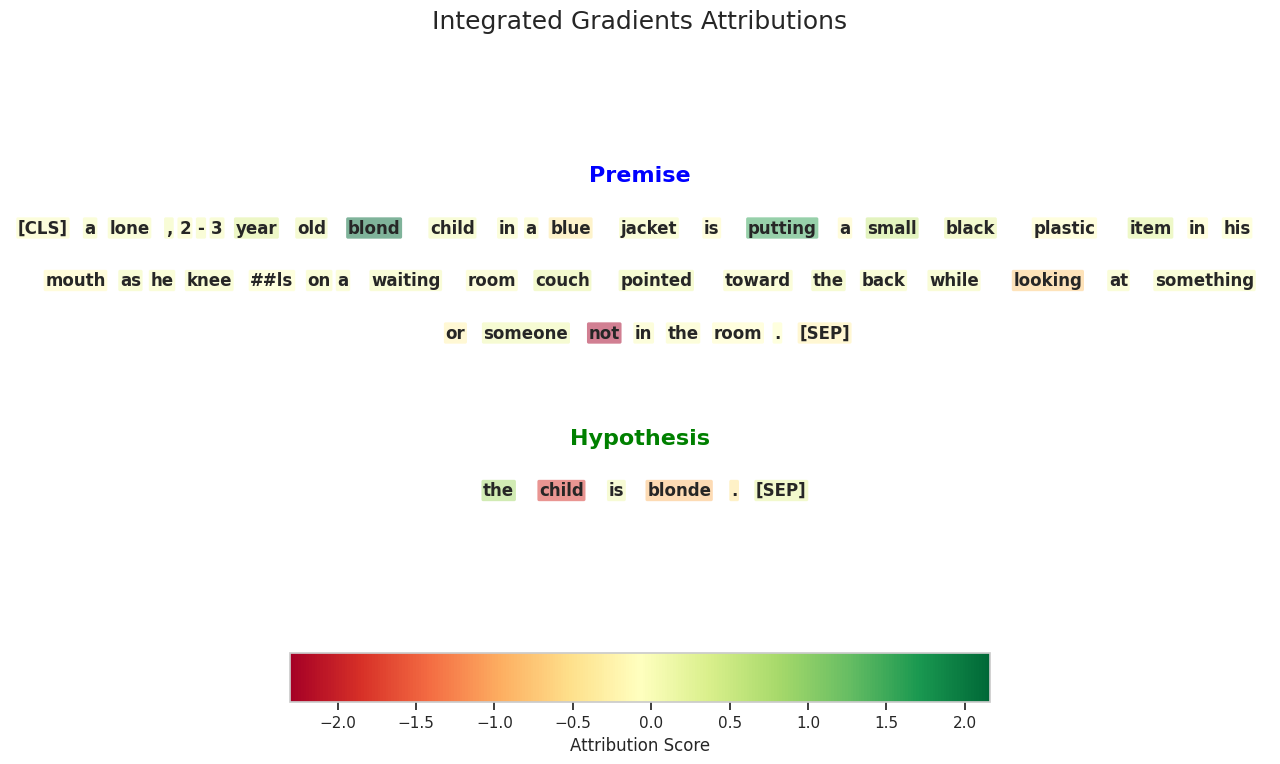

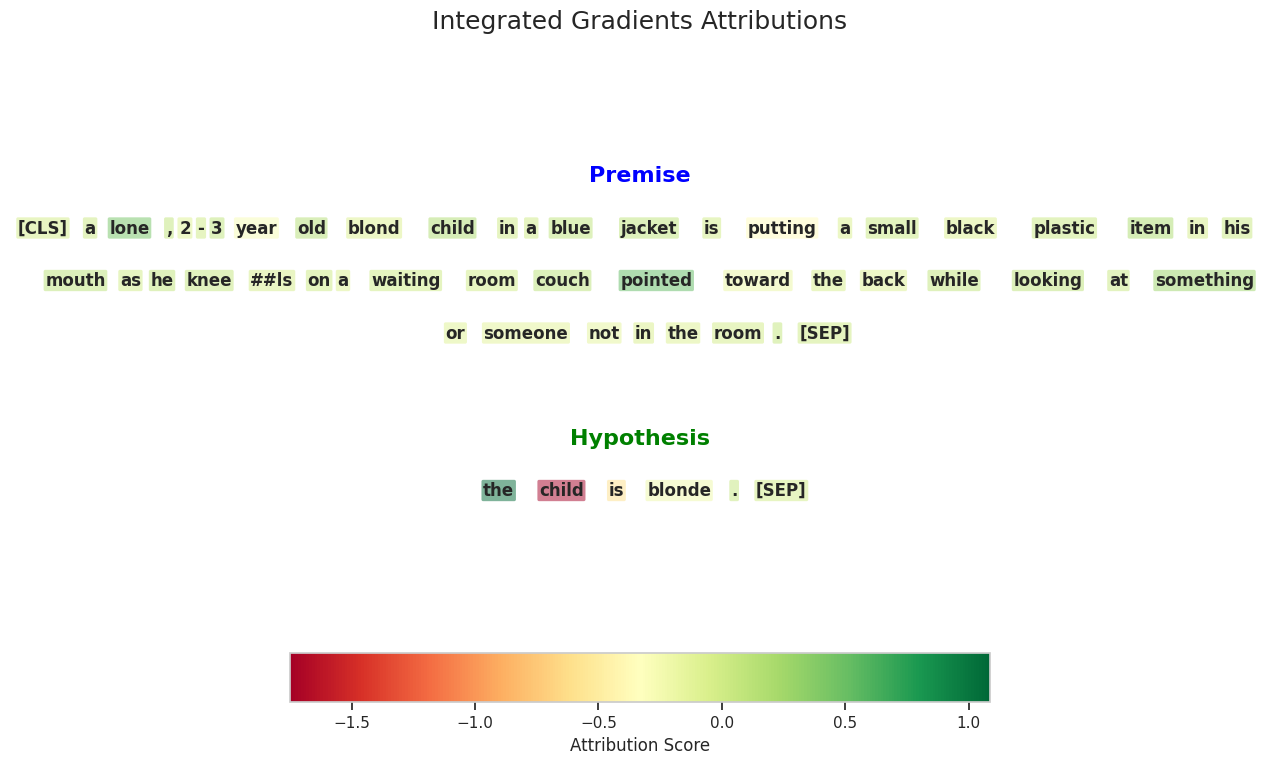

In [93]:
#import sys
#sys.path.append("drive/MyDrive/fp-dataset-artifacts-main")  # Add script directory to path
#from create_attributions import main  # Import main function

checkpoint_dir_parent = "/content/drive/MyDrive/fp-dataset-artifacts-main/trained_model_base_full/checkpoint-206013/"
checkpoint_dir = checkpoint_dir_parent + "eval_output/"

checkpoint_dir_parent_2 = "/content/drive/MyDrive/fp-dataset-artifacts-main/trained_model_variance_large/checkpoint-206013/"
checkpoint_dir_2 = checkpoint_dir_parent_2 + "eval_output/"


# Call main with arguments directly

premise = "A lone, 2-3 year old blond child in a blue jacket is putting a small black plastic item in his mouth as he kneels on a waiting room couch pointed toward the back while looking at something or someone not in the room."
hypothesis = "The child is blonde."
main(
    model_dir=checkpoint_dir_parent,
    premise=premise,
    hypothesis=hypothesis,
    create_vis=True
);
main(
    model_dir=checkpoint_dir_parent_2,
    premise=premise,
    hypothesis=hypothesis,
    create_vis=True
);

In [69]:
"""# None:
python run_ig.py --task nli --do_train \
--do_eval --max_train_samples 10000 \
--output_dir trained_model_base_small --ig_mode none | tee base_small_info.txt 2>&1

# Stopwords:
python run_ig.py --task nli --do_train \
--do_eval --max_train_samples 10000 \
--output_dir trained_model_stopwords_small --ig_mode stopwords | tee stopwords_small_info.txt 2>&1

# Variance:
python run_ig.py --task nli --do_train \
--do_eval --max_train_samples 10000 \
--output_dir trained_model_variance_small --ig_mode variance | tee variance_small_info.txt 2>&1

# Stopwords + Variance:
python run_ig.py --task nli --do_train \
--do_eval --max_train_samples 10000 \
--output_dir trained_model_both_small --ig_mode both | tee both_small_info.txt 2>&1



# Variance Large:
python run_ig.py --task nli --do_train \
--do_eval \
--output_dir trained_model_variance_large --ig_mode variance | tee variance_large_info.txt 2>&1

python your_script.py \
  --model google/electra-small-discriminator \
  --task nli \
  --dataset snli \
  --do_train \
  --do_eval \
  --output_dir ./checkpoints \
  --save_strategy steps \
  --save_steps 500 \
  --save_total_limit 3 \
  --resume_from_checkpoint ./checkpoints/checkpoint-1500 \

python run_ig.py --task nli --do_train \
--do_eval \
--output_dir trained_model_variance_large --ig_mode variance \
--resume_from_checkpoint /content/drive/MyDrive/fp-dataset-artifacts-main/trained_model_variance_large/checkpoint-148500 | tee variance_large_info_2.txt 2>&1
"""

'# None:\npython run_ig.py --task nli --do_train --do_eval --max_train_samples 10000 --output_dir trained_model_base_small --ig_mode none | tee base_small_info.txt 2>&1\n\n# Stopwords:\npython run_ig.py --task nli --do_train --do_eval --max_train_samples 10000 --output_dir trained_model_stopwords_small --ig_mode stopwords | tee stopwords_small_info.txt 2>&1\n\n# Variance:\npython run_ig.py --task nli --do_train --do_eval --max_train_samples 10000 --output_dir trained_model_variance_small --ig_mode variance | tee variance_small_info.txt 2>&1\n\n# Stopwords + Variance:\npython run_ig.py --task nli --do_train --do_eval --max_train_samples 10000 --output_dir trained_model_both_small --ig_mode both | tee both_small_info.txt 2>&1\n\n\n\n# Variance Large:\npython run_ig.py --task nli --do_train --do_eval --output_dir trained_model_variance_large --ig_mode variance | tee variance_large_info.txt 2>&1\n\npython your_script.py   --model google/electra-small-discriminator   --task nli   --dataset 

In [70]:
"""Eval:
python3 run.py --do_eval --task nli --dataset snli \
  --model /content/drive/MyDrive/fp-dataset-artifacts-main/trained_model_variance_large/checkpoint-206013/ \
  --output_dir /content/drive/MyDrive/fp-dataset-artifacts-main/trained_model_variance_large/checkpoint-206013/eval_output/
"""

'Eval:\npython3 run.py --do_eval --task nli --dataset snli   --model /content/drive/MyDrive/fp-dataset-artifacts-main/trained_model_variance_large/checkpoint-206013/   --output_dir /content/drive/MyDrive/fp-dataset-artifacts-main/trained_model_variance_large/checkpoint-206013/eval_output/\n'

In [71]:
# Find incorrect predictions from checkpoint
import json
import matplotlib.pyplot as plt
from collections import Counter

errors = []
with open(checkpoint_dir + 'eval_predictions.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        if data['predicted_label'] != data['label']:
            errors.append(data)

# 0 : entailment
# 1 : neutral
# 2 : contradiction

for error in errors:
    print(error)
print(len(errors))
# Count how often certain words appear in failed examples
word_counter = Counter()
for err in errors:
    words = (err['premise'] + " " + err['hypothesis']).split()
    for w in words:
        word_counter[w.lower()] += 1

print("Top words in errors:", word_counter.most_common(20))


{'premise': 'A woman is doing a cartwheel while wearing a bikini in the sand next to the beach.', 'hypothesis': 'A woman is doing a cartwheel and falls on her head.', 'label': 2, 'predicted_scores': [-3.6943929195404053, 2.465874195098877, -0.10850231349468231], 'predicted_label': 1}
{'premise': 'Families waiting in line at an amusement park for their turn to ride.', 'hypothesis': 'People are waiting to see a movie.', 'label': 2, 'predicted_scores': [-3.488710403442383, 1.8576655387878418, 0.445492684841156], 'predicted_label': 1}
{'premise': 'At an outdoor event in an Asian-themed area, a crowd congregates as one person in a yellow Chinese dragon costume confronts the camera.', 'hypothesis': 'A crowd is in front of a camera', 'label': 1, 'predicted_scores': [3.7630364894866943, -1.143894076347351, -3.5108225345611572], 'predicted_label': 0}
{'premise': 'A man in a green jersey and rollerskates stumbles as a man in a black jersey appears to collide with him.', 'hypothesis': 'They both 

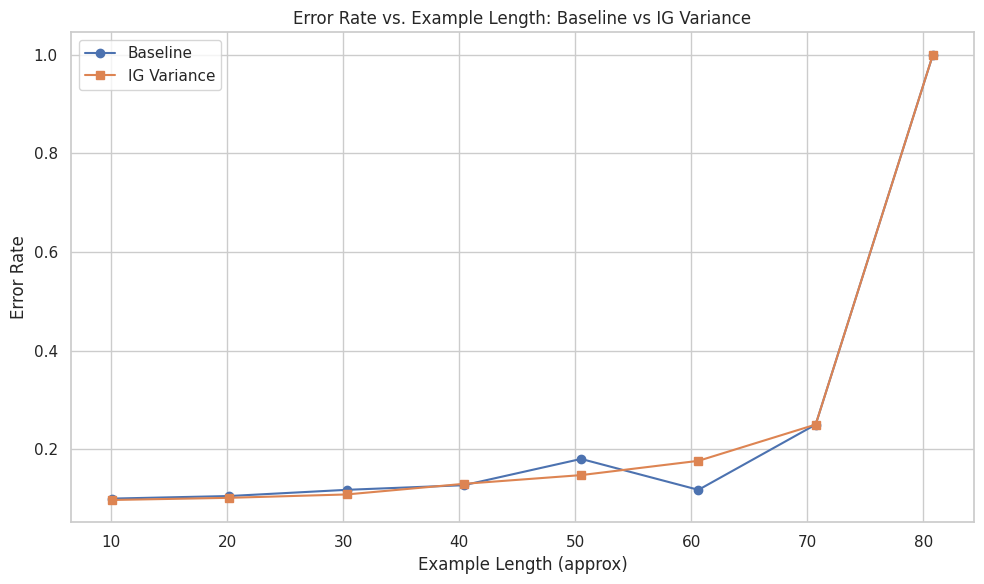

In [72]:
import json
import matplotlib.pyplot as plt
import numpy as np

def load_data(checkpoint_dir):
    """
    Load lengths and error indicators from a given checkpoint directory.

    Args:
        checkpoint_dir (str): Path to the checkpoint directory.

    Returns:
        lengths (np.ndarray): Array of example lengths.
        errors (np.ndarray): Array of error indicators (1 for error, 0 for correct).
    """
    lengths = []
    errors = []

    # Construct the full path to the eval_predictions.jsonl file
    filepath = checkpoint_dir.rstrip('/') + '/eval_predictions.jsonl'

    with open(filepath, 'r') as f:
        for line in f:
            ex = json.loads(line)
            # Calculate length as total tokens in premise and hypothesis
            premise_tokens = ex['premise'].split()
            hypothesis_tokens = ex['hypothesis'].split()
            ex_length = len(premise_tokens) + len(hypothesis_tokens)
            lengths.append(ex_length)

            # Determine if there's an error
            error = 1 if ex['predicted_label'] != ex['label'] else 0
            errors.append(error)

    return np.array(lengths), np.array(errors)

def compute_error_rates(lengths, errors, bin_edges):
    """
    Compute the error rate for each bin.

    Args:
        lengths (np.ndarray): Array of example lengths.
        errors (np.ndarray): Array of error indicators.
        bin_edges (np.ndarray): Array of bin edges.

    Returns:
        error_rates (list): List of error rates per bin.
    """
    bin_indices = np.digitize(lengths, bin_edges)
    error_rates = []

    for i in range(1, len(bin_edges)):
        bin_mask = (bin_indices == i)
        if bin_mask.sum() > 0:
            bin_error_rate = errors[bin_mask].mean()
        else:
            bin_error_rate = np.nan  # Use NaN for empty bins
        error_rates.append(bin_error_rate)

    return error_rates


# Load data from both directories
lengths_baseline, errors_baseline = load_data(checkpoint_dir)
lengths_ig, errors_ig = load_data(checkpoint_dir_2)

# Combine lengths to define common bin edges
all_lengths = np.concatenate([lengths_baseline, lengths_ig])
bin_edges = np.linspace(all_lengths.min(), all_lengths.max(), 10)  # 10 bins
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Compute error rates for both datasets
error_rates_baseline = compute_error_rates(lengths_baseline, errors_baseline, bin_edges)
error_rates_ig = compute_error_rates(lengths_ig, errors_ig, bin_edges)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, error_rates_baseline, marker='o', label='Baseline')
plt.plot(bin_centers, error_rates_ig, marker='s', label='IG Variance')

plt.xlabel('Example Length (approx)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Example Length: Baseline vs IG Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

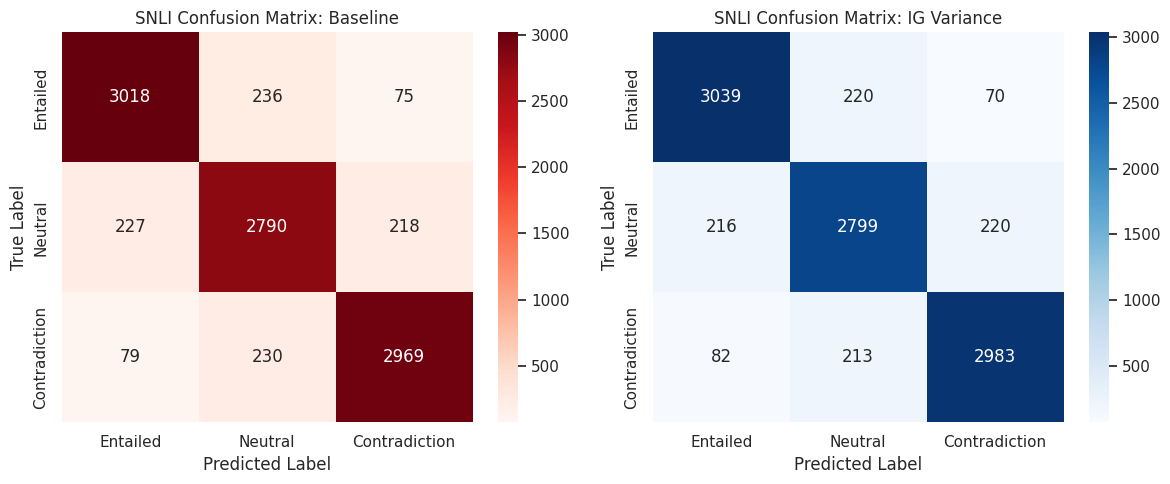

In [73]:
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def load_labels(checkpoint_dir):
    """
    Load true and predicted labels from a given checkpoint directory.

    Args:
        checkpoint_dir (str): Path to the checkpoint directory.

    Returns:
        true_labels (np.ndarray): Array of true labels.
        pred_labels (np.ndarray): Array of predicted labels.
    """
    true_labels = []
    pred_labels = []

    # Construct the full path to the eval_predictions.jsonl file
    filepath = checkpoint_dir.rstrip('/') + '/eval_predictions.jsonl'

    with open(filepath, 'r') as f:
        for line in f:
            ex = json.loads(line)
            true_labels.append(ex['label'])
            pred_labels.append(ex['predicted_label'])

    return np.array(true_labels), np.array(pred_labels)

def plot_confusion_matrices(checkpoint_dirs, titles, class_names, labels_order=[0,1,2]):
    """
    Plot confusion matrices for multiple checkpoints side by side.

    Args:
        checkpoint_dirs (list of str): List of checkpoint directory paths.
        titles (list of str): List of titles for each confusion matrix plot.
        class_names (list of str): List of class names.
        labels_order (list of int): List specifying the order of labels.
    """
    num_checks = len(checkpoint_dirs)
    plt.figure(figsize=(6 * num_checks, 5))  # Adjust figure size based on number of checkpoints

    cmaps = ["Reds", "Blues"]

    for idx, (ckpt_dir, title) in enumerate(zip(checkpoint_dirs, titles)):
        true_labels, pred_labels = load_labels(ckpt_dir)

        # Compute confusion matrix
        cm = confusion_matrix(true_labels, pred_labels, labels=labels_order)

        # Create a subplot for each confusion matrix
        plt.subplot(1, num_checks, idx + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps[idx],
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(title)

    plt.tight_layout()
    plt.show()

# Define class names and label order
class_names = ['Entailed', 'Neutral', 'Contradiction']
labels_order = [0, 1, 2]  # Assuming label mapping: 0=entailed, 1=neutral, 2=contradiction

# Define titles for each confusion matrix
titles = ['SNLI Confusion Matrix: Baseline', 'SNLI Confusion Matrix: IG Variance']

# List of checkpoint directories and corresponding titles
checkpoint_dirs = [checkpoint_dir, checkpoint_dir_2]

# Plot confusion matrices side by side
plot_confusion_matrices(checkpoint_dirs, titles, class_names, labels_order)

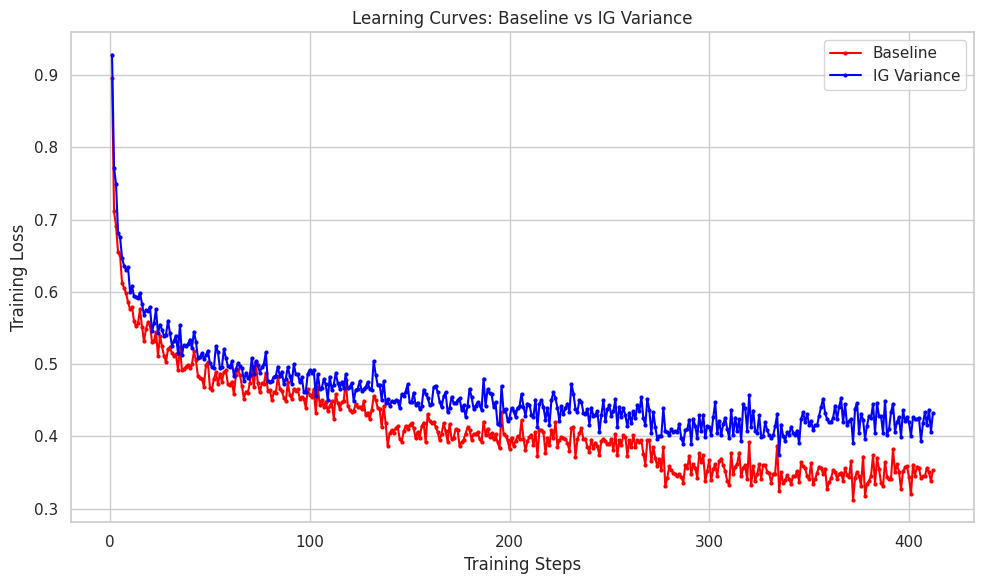

In [74]:
import json
import matplotlib.pyplot as plt
import os

def load_training_losses(checkpoint_dir):
    """
    Load training losses from the trainer_state.json file in a given checkpoint directory.

    Args:
        checkpoint_dir (str): Path to the checkpoint directory.

    Returns:
        train_steps (list of int): List of training step numbers.
        train_losses (list of float): List of training loss values.
    """
    log_file = os.path.join(checkpoint_dir.rstrip('/'), 'trainer_state.json')

    # Check if the log file exists
    if not os.path.isfile(log_file):
        raise FileNotFoundError(f"Log file not found: {log_file}")

    with open(log_file, 'r') as f:
        trainer_state = json.load(f)

    # Extract loss entries from log_history
    train_losses = [entry['loss'] for entry in trainer_state.get('log_history', []) if 'loss' in entry]
    train_steps = list(range(1, len(train_losses) + 1))

    return train_steps, train_losses

def plot_learning_curves(checkpoint_dirs, labels, colors=None):
    """
    Plot learning curves (training loss vs. steps) for multiple models on the same graph.

    Args:
        checkpoint_dirs (list of str): List of checkpoint directory paths.
        labels (list of str): List of labels corresponding to each checkpoint.
        colors (list of str, optional): List of colors for each plot. Defaults to None.
    """
    plt.figure(figsize=(10, 6))

    # Optionally define colors if not provided
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    colors = ["red", "blue"]

    for idx, (ckpt_dir, label) in enumerate(zip(checkpoint_dirs, labels)):
        try:
            train_steps, train_losses = load_training_losses(ckpt_dir)
            plt.plot(train_steps, train_losses, label=label, color=colors[idx % len(colors)], marker='o', linestyle='-', ms=2)
        except FileNotFoundError as e:
            print(e)

    plt.xlabel('Training Steps')
    plt.ylabel('Training Loss')
    plt.title('Learning Curves: Baseline vs IG Variance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define your checkpoint directories

# Define labels for each checkpoint
labels = ['Baseline', 'IG Variance']

# List of checkpoint directories
checkpoint_dirs = [checkpoint_dir_parent, checkpoint_dir_parent_2]

# Optionally define colors (ensure there are enough colors for all checkpoints)
colors = ['blue', 'green']  # You can choose any colors you prefer

# Plot the learning curves
plot_learning_curves(checkpoint_dirs, labels, colors)

In [75]:
import json

# Load misclassified examples
misclassified = []
with open(checkpoint_dir + 'eval_predictions.jsonl', 'r') as f:
    for line in f:
        ex = json.loads(line)
        if ex['predicted_label'] != ex['label']:
            misclassified.append(ex)

# Select top N misclassified examples (e.g., by confidence)
top_misclassified = sorted(misclassified, key=lambda x: max(x['predicted_scores']), reverse=True)[:10]

for ex in top_misclassified:
    print(f"Premise: {ex['premise']}")
    print(f"Hypothesis: {ex['hypothesis']}")
    print(f"True Label: {ex['label']}, Predicted Label: {ex['predicted_label']}")
    print(f"Predicted Probabilities: {ex['predicted_scores']}\n")

Premise: A group of people are standing in front of parked bicycles on a corner with various carrying bags on the ground.
Hypothesis: The group of people are sitting around having a picnic.
True Label: 1, Predicted Label: 2
Predicted Probabilities: [-4.918878555297852, -2.736497640609741, 5.269183158874512]

Premise: A male construction worker hammers a nail.
Hypothesis: A construction worker drives the nail into the kitchen wall.
True Label: 1, Predicted Label: 2
Predicted Probabilities: [-5.016189098358154, -2.4716298580169678, 5.136746406555176]

Premise: the shadow silhouette of a woman standing near the water looking at a large attraction on the other side.
Hypothesis: She is eating a corn dog.
True Label: 1, Predicted Label: 2
Predicted Probabilities: [-5.553973197937012, -1.9320354461669922, 5.099376201629639]

Premise: Two women looking at the camera and a man looking away.
Hypothesis: A group of people hugging.
True Label: 1, Predicted Label: 2
Predicted Probabilities: [-4.654

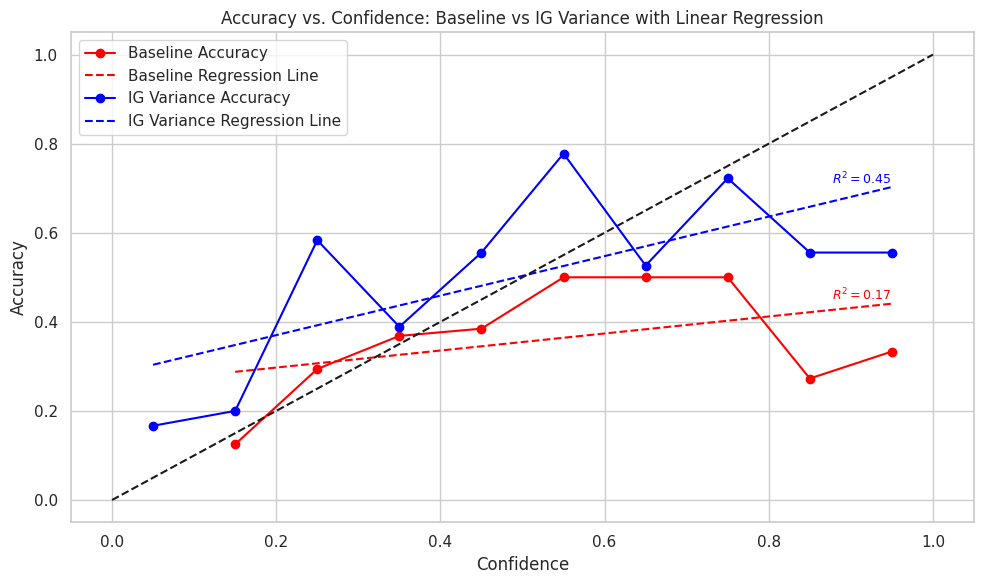

In [76]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LinearRegression

def load_confidences_and_correct(checkpoint_dir):
    """
    Load confidence scores and correctness indicators from a given checkpoint directory.

    Args:
        checkpoint_dir (str): Path to the checkpoint directory.

    Returns:
        confidences (np.ndarray): Array of confidence scores.
        correct (np.ndarray): Array indicating correctness (1 for correct, 0 for incorrect).
    """
    confidences = []
    correct = []

    # Construct the full path to the eval_predictions.jsonl file
    filepath = os.path.join(checkpoint_dir.rstrip('/'), 'eval_predictions.jsonl')

    # Check if the file exists
    if not os.path.isfile(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    with open(filepath, 'r') as f:
        for line in f:
            ex = json.loads(line)
            predicted_label = ex['predicted_label']
            true_label = ex['label']
            predicted_scores = ex.get('predicted_scores', [])

            # Ensure predicted_scores is a list and predicted_label is a valid index
            if isinstance(predicted_scores, list) and isinstance(predicted_label, int):
                if 0 <= predicted_label < len(predicted_scores):
                    confidence = predicted_scores[predicted_label]
                else:
                    print(f"Warning: predicted_label {predicted_label} out of range for predicted_scores {predicted_scores}. Assigning confidence=0.0")
                    confidence = 0.0
            else:
                print(f"Warning: Invalid format for predicted_scores or predicted_label in example: {ex}. Assigning confidence=0.0")
                confidence = 0.0

            confidences.append(confidence)
            correct.append(1 if predicted_label == true_label else 0)

    return np.array(confidences), np.array(correct)

def compute_accuracy_per_bin(confidences, correct, bins):
    """
    Compute the accuracy for each confidence bin.

    Args:
        confidences (np.ndarray): Array of confidence scores.
        correct (np.ndarray): Array indicating correctness.
        bins (np.ndarray): Array of bin edges.

    Returns:
        bin_centers (np.ndarray): Centers of the bins.
        accuracy_per_bin (list): List of accuracies per bin.
    """
    bin_indices = np.digitize(confidences, bins)
    accuracy_per_bin = []
    bin_centers = []

    for i in range(1, len(bins)):
        bin_mask = (bin_indices == i)
        if bin_mask.sum() > 0:
            bin_accuracy = correct[bin_mask].mean()
        else:
            # If no data in bin, assign NaN
            bin_accuracy = np.nan
        accuracy_per_bin.append(bin_accuracy)
        # Calculate the center of the bin for plotting
        bin_center = (bins[i] + bins[i-1]) / 2
        bin_centers.append(bin_center)

    return np.array(bin_centers), accuracy_per_bin

def plot_accuracy_vs_confidence_with_regression(checkpoint_dirs, labels, colors=None, bins=np.linspace(0, 1, 11)):
    """
    Plot Accuracy vs. Confidence for multiple models on the same graph with linear regression lines.

    Args:
        checkpoint_dirs (list of str): List of checkpoint directory paths.
        labels (list of str): List of labels corresponding to each checkpoint.
        colors (list of str, optional): List of colors for each plot. Defaults to None.
        bins (np.ndarray, optional): Array of bin edges. Defaults to np.linspace(0, 1, 11).
    """
    plt.figure(figsize=(10, 6))

    # If colors are not provided, use default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for idx, (ckpt_dir, label) in enumerate(zip(checkpoint_dirs, labels)):
        try:
            confidences, correct = load_confidences_and_correct(ckpt_dir)
            bin_centers, accuracy_per_bin = compute_accuracy_per_bin(confidences, correct, bins)

            # Mask out NaN values for regression
            valid_mask = ~np.isnan(accuracy_per_bin)
            valid_bin_centers = bin_centers[valid_mask]
            valid_accuracy = np.array(accuracy_per_bin)[valid_mask]

            # Reshape for sklearn
            X = valid_bin_centers.reshape(-1, 1)
            y = valid_accuracy

            # Fit linear regression
            reg = LinearRegression()
            reg.fit(X, y)
            y_pred = reg.predict(X)

            # Plot the Accuracy vs Confidence curve
            plt.plot(bin_centers, accuracy_per_bin, marker='o', label=f'{label} Accuracy', color=colors[idx % len(colors)], linestyle='-')

            # Plot the Linear Regression line
            plt.plot(valid_bin_centers, y_pred, color=colors[idx % len(colors)], linestyle='--', label=f'{label} Regression Line')

            # Optionally, display the regression equation and R² score
            slope = reg.coef_[0]
            intercept = reg.intercept_
            r_squared = reg.score(X, y)
            plt.text(
                valid_bin_centers[-1],
                y_pred[-1],
                f'$R^2={r_squared:.2f}$',
                color=colors[idx % len(colors)],
                fontsize=9,
                verticalalignment='bottom',
                horizontalalignment='right'
            )

        except FileNotFoundError as e:
            print(e)
            continue

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Confidence: Baseline vs IG Variance with Linear Regression')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Define labels for each checkpoint
labels = ['Baseline', 'IG Variance']

# List of checkpoint directories
checkpoint_dirs = [checkpoint_dir, checkpoint_dir_2]

# Optionally define colors (ensure there are enough colors for all checkpoints)
colors = ['red', 'blue']  # Customize as needed

# Plot the Accuracy vs. Confidence curves with Linear Regression lines
plot_accuracy_vs_confidence_with_regression(checkpoint_dirs, labels, colors)

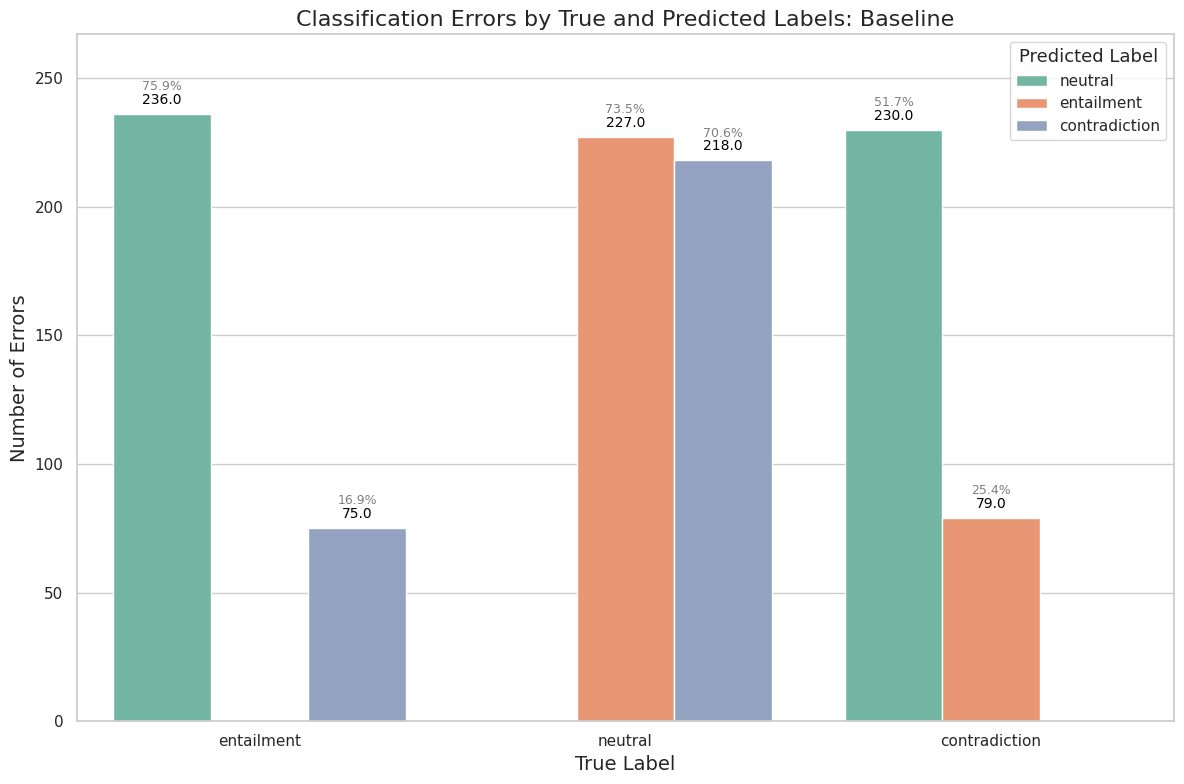

In [87]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Define your class names in the desired order
class_names = ["entailment", "neutral", "contradiction"]  # Ensure this matches your actual classes

# Collect errors where predicted_label != label and all labels
errors = []
true_labels = []
predicted_labels = []
with open(checkpoint_dir + 'eval_predictions.jsonl', 'r') as f:
    for line in f:
        ex = json.loads(line)
        true = ex['label']
        pred = ex['predicted_label']
        true_labels.append(true)
        predicted_labels.append(pred)
        if pred != true:
            errors.append({
                'True Label': class_names[true],
                'Predicted Label': class_names[pred]
            })

# Create DataFrame from errors
df_errors = pd.DataFrame(errors)

# Define the desired order for the true labels
desired_order = ["entailment", "neutral", "contradiction"]  # Update this list if your class names differ

# Check if there are errors to plot
if df_errors.empty:
    print("No errors found in the predictions.")
else:
    plt.figure(figsize=(12, 8))  # Increased figure size for better readability

    # Create count plot with the specified order and a more distinguishable palette
    ax = sns.countplot(
        x='True Label',
        hue='Predicted Label',
        data=df_errors,
        order=desired_order,  # Ensures the x-axis follows the desired order
        palette='Set2'  # Choose a palette with distinct colors
    )

    # Add count labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(
                f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points'
            )

    # Calculate percentages for annotations
    # Group by 'True Label' to calculate percentages within each true label category
    total_errors_per_true_label = df_errors.groupby('True Label').size().reindex(desired_order, fill_value=0)

    # Iterate over each bar to add percentage annotations
    for i, true_label in enumerate(desired_order):
        # Total errors for the current true label
        total = total_errors_per_true_label[true_label]
        if total == 0:
            continue  # Avoid division by zero

        # Get the positions of the bars for the current true label
        for j, p in enumerate(ax.patches[i::len(desired_order)]):
            height = p.get_height()
            if height > 0:
                percentage = (height / total) * 100
                ax.annotate(
                    f'{percentage:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    color='gray',
                    xytext=(0, 15),  # 15 points vertical offset to prevent overlap
                    textcoords='offset points'
                )

    # Set labels and title with improved font sizes
    plt.xlabel('True Label', fontsize=14)
    plt.ylabel('Number of Errors', fontsize=14)
    plt.title('Classification Errors by True and Predicted Labels: Baseline', fontsize=16)

    # Improve legend
    plt.legend(title='Predicted Label', title_fontsize='13', fontsize='11')


    # Adjust y-axis limit to provide more space at the top
    max_count = df_errors['True Label'].value_counts().max()
    plt.ylim(0, max_count * 0.6)

    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

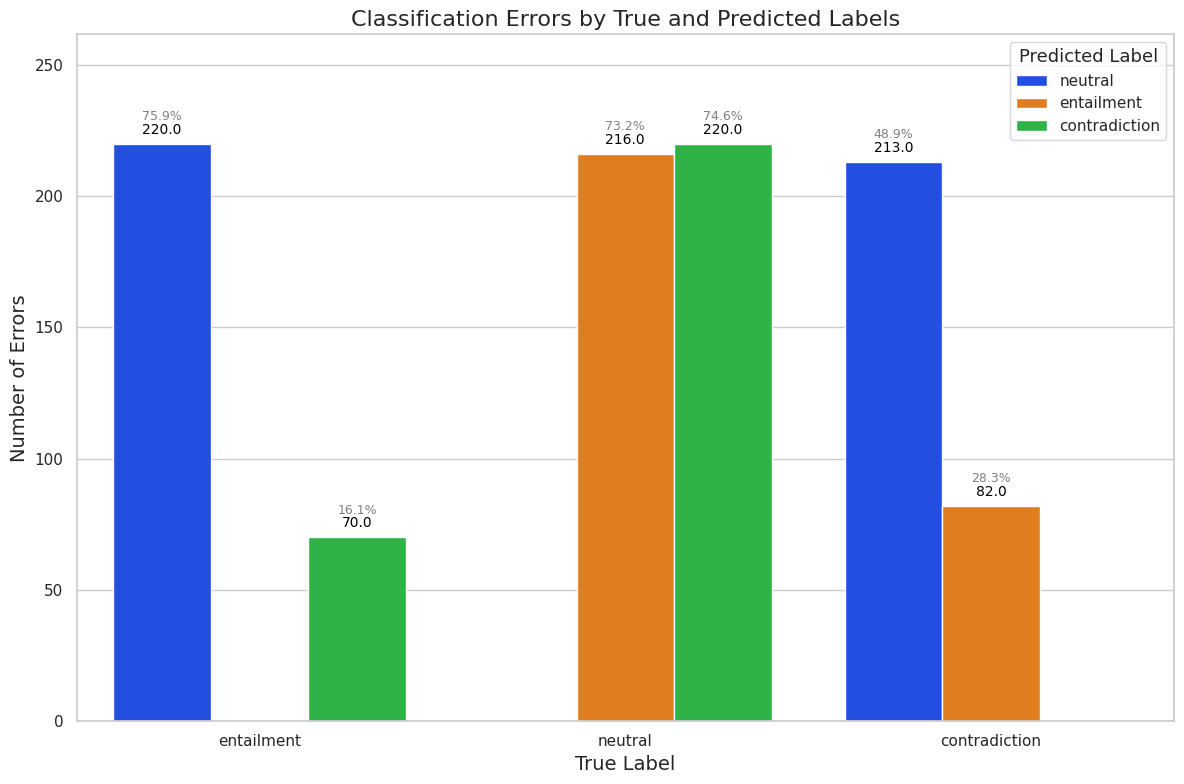

In [86]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Define your class names in the desired order
class_names = ["entailment", "neutral", "contradiction"]  # Ensure this matches your actual classes

# Collect errors where predicted_label != label and all labels
errors = []
true_labels = []
predicted_labels = []
with open(checkpoint_dir_2 + 'eval_predictions.jsonl', 'r') as f:
    for line in f:
        ex = json.loads(line)
        true = ex['label']
        pred = ex['predicted_label']
        true_labels.append(true)
        predicted_labels.append(pred)
        if pred != true:
            errors.append({
                'True Label': class_names[true],
                'Predicted Label': class_names[pred]
            })

# Create DataFrame from errors
df_errors = pd.DataFrame(errors)

# Define the desired order for the true labels
desired_order = ["entailment", "neutral", "contradiction"]  # Update this list if your class names differ

# Check if there are errors to plot
if df_errors.empty:
    print("No errors found in the predictions.")
else:
    plt.figure(figsize=(12, 8))  # Increased figure size for better readability

    # Create count plot with the specified order and a more distinguishable palette
    ax = sns.countplot(
        x='True Label',
        hue='Predicted Label',
        data=df_errors,
        order=desired_order,  # Ensures the x-axis follows the desired order
        palette='bright'  # Choose a palette with distinct colors
    )

    # Add count labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(
                f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points'
            )

    # Calculate percentages for annotations
    # Group by 'True Label' to calculate percentages within each true label category
    total_errors_per_true_label = df_errors.groupby('True Label').size().reindex(desired_order, fill_value=0)

    # Iterate over each bar to add percentage annotations
    for i, true_label in enumerate(desired_order):
        # Total errors for the current true label
        total = total_errors_per_true_label[true_label]
        if total == 0:
            continue  # Avoid division by zero

        # Get the positions of the bars for the current true label
        for j, p in enumerate(ax.patches[i::len(desired_order)]):
            height = p.get_height()
            if height > 0:
                percentage = (height / total) * 100
                ax.annotate(
                    f'{percentage:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    color='gray',
                    xytext=(0, 15),  # 15 points vertical offset to prevent overlap
                    textcoords='offset points'
                )

    # Set labels and title with improved font sizes
    plt.xlabel('True Label', fontsize=14)
    plt.ylabel('Number of Errors', fontsize=14)
    plt.title('Classification Errors by True and Predicted Labels: IG Variance', fontsize=16)

    # Improve legend
    plt.legend(title='Predicted Label', title_fontsize='13', fontsize='11')


    # Adjust y-axis limit to provide more space at the top
    max_count = df_errors['True Label'].value_counts().max()
    plt.ylim(0, max_count * 0.6)

    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

In [78]:
import json
import os

def load_predictions(checkpoint_dir):
    """
    Load predictions from the eval_predictions.jsonl file in the given checkpoint directory.

    Args:
        checkpoint_dir (str): Path to the checkpoint directory.

    Returns:
        list of dict: List containing prediction dictionaries.
    """
    predictions = []
    filepath = os.path.join(checkpoint_dir.rstrip('/'), 'eval_predictions.jsonl')

    # Check if the file exists
    if not os.path.isfile(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    with open(filepath, 'r') as f:
        for line_number, line in enumerate(f, 1):
            try:
                ex = json.loads(line)
                predictions.append(ex)
            except json.JSONDecodeError as e:
                print(f"JSON decoding error in line {line_number} of {filepath}: {e}")

    return predictions

def find_ig_correct_baseline_incorrect(baseline_preds, ig_preds):
    """
    Identify examples where IG Variance got the prediction right and Baseline did not.

    Args:
        baseline_preds (list of dict): Predictions from the Baseline model.
        ig_preds (list of dict): Predictions from the IG Variance model.

    Returns:
        list of dict: List of examples satisfying the condition.
    """
    if len(baseline_preds) != len(ig_preds):
        raise ValueError("The number of predictions in Baseline and IG Variance do not match.")

    # List to store the specific examples
    specific_examples = []

    for idx, (baseline_ex, ig_ex) in enumerate(zip(baseline_preds, ig_preds), 1):
        baseline_correct = baseline_ex['predicted_label'] == baseline_ex['label']
        ig_correct = ig_ex['predicted_label'] == ig_ex['label']

        if ig_correct and not baseline_correct:
            # Optionally, include more details as needed
            example_detail = {
                'Example Number': idx,
                'Premise': ig_ex.get('premise', 'N/A'),
                'Hypothesis': ig_ex.get('hypothesis', 'N/A'),
                'True Label': ig_ex.get('label', 'N/A'),
                'Baseline Prediction': baseline_ex.get('predicted_label', 'N/A'),
                'IG Variance Prediction': ig_ex.get('predicted_label', 'N/A'),
                # Include other fields if necessary
            }
            specific_examples.append(example_detail)

    return specific_examples

def print_specific_examples(specific_examples):
    """
    Print the specific examples where IG Variance got it right and Baseline didn't.

    Args:
        specific_examples (list of dict): List of example details.
    """
    if not specific_examples:
        print("No examples found where IG Variance got it right and Baseline did not.")
        return

    print(f"Total Examples where IG Variance got it right and Baseline did not: {len(specific_examples)}\n")

    for ex in specific_examples:
        print(f"Example Number: {ex['Example Number']}")
        print(f"Premise: {ex['Premise']}")
        print(f"Hypothesis: {ex['Hypothesis']}")
        print(f"True Label: {ex['True Label']}")
        print(f"Baseline Prediction: {ex['Baseline Prediction']}")
        print(f"IG Variance Prediction: {ex['IG Variance Prediction']}")
        print("-" * 80)

def save_specific_examples_to_file(specific_examples, output_file='ig_correct_baseline_incorrect.jsonl'):
    """
    Save the specific examples to a JSONL file.

    Args:
        specific_examples (list of dict): List of example details.
        output_file (str): Filename for the output JSONL file.
    """
    with open(output_file, 'w') as f:
        for ex in specific_examples:
            f.write(json.dumps(ex) + '\n')
    print(f"Specific examples saved to {output_file}")

def main():

    # Load predictions from both checkpoints
    print("Loading Baseline predictions...")
    baseline_preds = load_predictions(checkpoint_dir)
    print(f"Loaded {len(baseline_preds)} predictions from Baseline.\n")

    print("Loading IG Variance predictions...")
    ig_preds = load_predictions(checkpoint_dir_2)
    print(f"Loaded {len(ig_preds)} predictions from IG Variance.\n")

    # Find specific examples
    print("Identifying specific examples where IG Variance got it right and Baseline did not...")
    specific_examples = find_ig_correct_baseline_incorrect(baseline_preds, ig_preds)

    # Print the examples
    print_specific_examples(specific_examples)

    # Optionally, save the examples to a file
    save_specific_examples_to_file(specific_examples)

if __name__ == "__main__":
    main()

Loading Baseline predictions...
Loaded 9842 predictions from Baseline.

Loading IG Variance predictions...
Loaded 9842 predictions from IG Variance.

Identifying specific examples where IG Variance got it right and Baseline did not...
Total Examples where IG Variance got it right and Baseline did not: 270

Example Number: 70
Premise: A taxi SUV drives past an urban construction site, as a man walks down the street in the other direction.
Hypothesis: An SUV and a man are going in opposite directions.
True Label: 0
Baseline Prediction: 2
IG Variance Prediction: 0
--------------------------------------------------------------------------------
Example Number: 87
Premise: The two farmers are working on a piece of John Deere equipment.
Hypothesis: Men are working on John Deere equipment
True Label: 0
Baseline Prediction: 1
IG Variance Prediction: 0
--------------------------------------------------------------------------------
Example Number: 93
Premise: A woman is writing something on a p